# <span style="color:blue">LDA model (2019_Apr) - 10 topics</span>

In [1]:
yyyy_MMM = '2019_Apr'

### Load packages

In [2]:
import csv, os, re, time
import numpy as np
from numpy import savetxt
import pandas as  pd
import matplotlib.pyplot as plt  
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
from pprint import pprint
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\models\doc

True

### Constants

In [3]:
# for reproducible results
random_state = 33
# if the test is True, the process runs on a smaller subset of raw data (json files)
test = False
# if sample > 0, then we take a sample of the entire dataset (for debugging purpose)
sample = 0
# parameters to build the lda model
num_topics = 10

if test:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model'
    # chunksize to build LDA model
    chunksize = 250
else:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model'
    # chunksize to build LDA model
    chunksize = 5000

# path + name of the file that contains the documents preprocessed
file_doc = os.path.join(path_doc, yyyy_MMM, yyyy_MMM) + '_28_results.csv'
# path + name of the file that contains the model gotten at the end
file_model = os.path.join(path_model, yyyy_MMM, 'model')
print(file_doc)
print(file_model)

D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc\2019_Apr\2019_Apr_28_results.csv
D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model\2019_Apr\model


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data preprocessed

In [4]:
df = pd.read_csv(file_doc, index_col='id_doc')
documents = df.content_preprocessed
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
1513164    ['today', 'stable', 'situation', 'detail', 'sh...
747496     ['ready', 'video', 'style', 'fall', 'link', 'p...
1324209    ['polish', 'polska', 'dziewczyna', 'brunette',...
341929                                             ['third']
1546841    ['archive', 'italia', 'damon', 'hall', 'booth'...
804007     ['vale', 'mesmo', 'pelos', 'youtube', 'galera'...
132655     ['smile', 'weekend', 'grand', 'prix', 'formula...
1441477    ['forward', 'year', 'long', 'gggg', 'morph', '...
564612     ['vibe', 'london', 'city', 'captivate', 'fast'...
1472936    ['congratulation', 'beautiful', 'hend', 'tasne...
Name: content_preprocessed, dtype: object

### Shuffle

In [5]:
documents = documents.sample(frac=1, random_state=random_state)
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
541250     ['scent', 'ford', 'metalli', 'fearless', 'bold...
1291946    ['babe', 'roshan', 'osha', 'afridi', 'brow', '...
786049     ['wear', 'store', 'archive', 'edition', 'inspi...
167502     ['rock', 'baby', 'nonstop', 'thing', 'love', '...
1319982    ['kitty', 'double', 'leave', 'moji', 'hallowee...
932000     ['love', 'best', 'picture', 'love', 'family', ...
351602     ['hello', 'office', 'space', 'officially', 'tu...
356625     ['buenos', 'lunes', 'arran', 'camo', 'semana',...
1406137    ['dreamy', 'combination', 'traditional', 'chec...
522188     ['reserve', 'outfit', 'tello', 'clothing', 'cr...
Name: content_preprocessed, dtype: object

### Sample

In [6]:
if sample > 0:
    documents = documents.sample(n=sample, random_state=random_state)
    print(documents.head(10))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot the number of words appearing in each document  

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(148091,)


<AxesSubplot:>

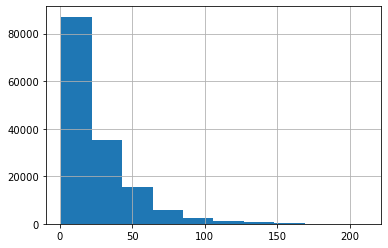

In [7]:
print(documents.shape)

documents.str.split().\
    map(lambda x: len(x)).\
    hist()

### Remove words that appear only once

In [8]:
####################### PENDING

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenize words and Clean-up text

In [9]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute bigrams & trigrams  

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents

In [10]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear min_count times or more).
def bi_tri_grams(documents, min_count):
    bigram = Phrases(documents, min_count=min_count)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Categorizing and tagging words

In [11]:
# function to remove accented characters
def tag_words(text):
    tags = nltk.pos_tag(text)
    nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return nouns

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dictionary with the entire dataset

In [12]:
data_words = list(sent_to_words(documents))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# Create Dictionary
id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus_total = [id2word.doc2bow(text) for text in texts]

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Save document-term matrix

In [13]:
# save document-term matrix
savetxt(file_model + '_document_term_matrix.csv', corpus_total, delimiter=',', fmt='% s')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Build LDA model

In [14]:
perplexity_score = []
coherence_score = []
indixes = []

index = 0
chunk_size = 250
documents_sample = documents[index:chunk_size-1]

time_start = time.time()

data_words = list(sent_to_words(documents_sample))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# # Create Dictionary
# id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus
                                       ,id2word=id2word
                                       ,num_topics=num_topics
                                       ,random_state=random_state
                                       ,chunksize=chunksize
                                       ,passes=50
                                       ,per_word_topics=True)

indixes.append(index)

# Evaluate LDA Model
# Compute Perplexity Score
perplexity = lda_model.log_perplexity(corpus)
perplexity_score.append(perplexity)

# Evaluate LDA Model
# Compute Coherence Score
coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence = coherence_lda_model.get_coherence()
coherence_score.append(coherence)

# Save LDA Model
temp_file = datapath(file_model)
lda_model.save(temp_file)
temp_file = datapath(file_model + '_' + str(index).zfill(5))
lda_model.save(temp_file)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:38.97


### Incremental learning

In [15]:
documents_len = len(documents)

while index+(index+1)*chunk_size < documents_len:
    
    time_start = time.time()
    
    print(index, ' ----- ', (index+1)*chunk_size, ' ----- ', ((index+1)*chunk_size)+chunk_size-1)
    documents_sample = documents[(index+1)*chunk_size:((index+1)*chunk_size)+chunk_size-1]
    
    data_words = list(sent_to_words(documents_sample))
    # Compute bigrams & trigrams
    bi_tri_grams(data_words, 250)
    # Categorizing and tagging words
    data_words = list(map(tag_words, data_words))
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Load LDA Model
    temp_file = datapath(file_model)
    lda_model = gensim.models.ldamodel.LdaModel.load(temp_file)
    # Update LDA Model
    lda_model.update(corpus)
    
    index = index + 1
    indixes.append(index)
    
    # Evaluate LDA Model
    # Compute Perplexity Score
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_score.append(perplexity)

    # Evaluate LDA Model
    # Compute Coherence Score
    coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence = coherence_lda_model.get_coherence()
    coherence_score.append(coherence)
    
    # Save LDA Model
    temp_file = datapath(file_model)
    lda_model.save(temp_file)
    temp_file = datapath(file_model + '_' + str(index).zfill(5))
    lda_model.save(temp_file)
    
    time_end = time.time()
    hour, rem = divmod(time_end - time_start, 3600)
    minute, second = divmod(rem, 60)
    print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

0  -----  250  -----  499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:38.04
1  -----  500  -----  749
time elapsed - 00:00:37.40
2  -----  750  -----  999
time elapsed - 00:00:37.55
3  -----  1000  -----  1249
time elapsed - 00:00:37.17
4  -----  1250  -----  1499
time elapsed - 00:00:37.31
5  -----  1500  -----  1749
time elapsed - 00:00:37.16
6  -----  1750  -----  1999
time elapsed - 00:00:37.11
7  -----  2000  -----  2249
time elapsed - 00:00:36.34
8  -----  2250  -----  2499
time elapsed - 00:00:38.72
9  -----  2500  -----  2749
time elapsed - 00:00:38.40
10  -----  2750  -----  2999
time elapsed - 00:00:38.07
11  -----  3000  -----  3249
time elapsed - 00:00:38.22
12  -----  3250  -----  3499
time elapsed - 00:00:37.32
13  -----  3500  -----  3749
time elapsed - 00:00:37.20
14  -----  3750  -----  3999
time elapsed - 00:00:37.35
15  -----  4000  -----  4249
time elapsed - 00:00:38.02
16  -----  4250  -----  4499
time elapsed - 00:00:38.04
17  -----  4500  -----  4749
time elapsed - 00:00:39.56
18  -----  4750  -----  4999
time 

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:37.40
21  -----  5500  -----  5749
time elapsed - 00:00:38.05
22  -----  5750  -----  5999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:37.91
23  -----  6000  -----  6249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:37.87
24  -----  6250  -----  6499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:37.76
25  -----  6500  -----  6749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:37.98
26  -----  6750  -----  6999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.95
27  -----  7000  -----  7249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:46.18
28  -----  7250  -----  7499
time elapsed - 00:00:44.66
29  -----  7500  -----  7749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.38
30  -----  7750  -----  7999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.70
31  -----  8000  -----  8249
time elapsed - 00:00:43.03
32  -----  8250  -----  8499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.06
33  -----  8500  -----  8749
time elapsed - 00:00:46.23
34  -----  8750  -----  8999
time elapsed - 00:00:48.11
35  -----  9000  -----  9249
time elapsed - 00:00:44.13
36  -----  9250  -----  9499
time elapsed - 00:00:44.38
37  -----  9500  -----  9749
time elapsed - 00:00:43.08
38  -----  9750  -----  9999
time elapsed - 00:00:43.73
39  -----  10000  -----  10249
time elapsed - 00:00:44.31
40  -----  10250  -----  10499
time elapsed - 00:00:43.60
41  -----  10500  -----  10749
time elapsed - 00:00:46.06
42  -----  10750  -----  10999
time elapsed - 00:00:45.89
43  -----  11000  -----  11249
time elapsed - 00:00:45.87
44  -----  11250  -----  11499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.31
45  -----  11500  -----  11749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.49
46  -----  11750  -----  11999
time elapsed - 00:00:45.49
47  -----  12000  -----  12249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:46.53
48  -----  12250  -----  12499
time elapsed - 00:00:43.71
49  -----  12500  -----  12749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.69
50  -----  12750  -----  12999
time elapsed - 00:00:42.80
51  -----  13000  -----  13249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.61
52  -----  13250  -----  13499
time elapsed - 00:00:43.43
53  -----  13500  -----  13749
time elapsed - 00:00:42.87
54  -----  13750  -----  13999
time elapsed - 00:00:43.05
55  -----  14000  -----  14249
time elapsed - 00:00:42.71
56  -----  14250  -----  14499
time elapsed - 00:00:42.89
57  -----  14500  -----  14749
time elapsed - 00:00:43.69
58  -----  14750  -----  14999
time elapsed - 00:00:44.30
59  -----  15000  -----  15249
time elapsed - 00:00:42.30
60  -----  15250  -----  15499
time elapsed - 00:00:43.62
61  -----  15500  -----  15749
time elapsed - 00:00:43.48
62  -----  15750  -----  15999
time elapsed - 00:00:39.70
63  -----  16000  -----  16249
time elapsed - 00:00:44.65
64  -----  16250  -----  16499
time elapsed - 00:00:45.72
65  -----  16500  -----  16749
time elapsed - 00:00:44.80
66  -----  16750  -----  16999
time elapsed - 00:00:45.70
67  -----  17000  -----  17249
time elapsed - 00:00:46.91
68  -----  17250  -----  17499
time elapsed -

time elapsed - 00:00:38.33
192  -----  48250  -----  48499
time elapsed - 00:00:37.78
193  -----  48500  -----  48749
time elapsed - 00:00:37.79
194  -----  48750  -----  48999
time elapsed - 00:00:38.25
195  -----  49000  -----  49249
time elapsed - 00:00:37.89
196  -----  49250  -----  49499
time elapsed - 00:00:38.07
197  -----  49500  -----  49749
time elapsed - 00:00:37.54
198  -----  49750  -----  49999
time elapsed - 00:00:37.84
199  -----  50000  -----  50249
time elapsed - 00:00:38.68
200  -----  50250  -----  50499
time elapsed - 00:00:37.87
201  -----  50500  -----  50749
time elapsed - 00:00:38.18
202  -----  50750  -----  50999
time elapsed - 00:00:37.97
203  -----  51000  -----  51249
time elapsed - 00:00:38.70
204  -----  51250  -----  51499
time elapsed - 00:00:38.11
205  -----  51500  -----  51749
time elapsed - 00:00:38.13
206  -----  51750  -----  51999
time elapsed - 00:00:37.92
207  -----  52000  -----  52249
time elapsed - 00:00:38.99
208  -----  52250  -----  524

time elapsed - 00:00:38.81
331  -----  83000  -----  83249
time elapsed - 00:00:38.70
332  -----  83250  -----  83499
time elapsed - 00:00:37.97
333  -----  83500  -----  83749
time elapsed - 00:00:38.41
334  -----  83750  -----  83999
time elapsed - 00:00:38.75
335  -----  84000  -----  84249
time elapsed - 00:00:38.12
336  -----  84250  -----  84499
time elapsed - 00:00:38.68
337  -----  84500  -----  84749
time elapsed - 00:00:38.43
338  -----  84750  -----  84999
time elapsed - 00:00:38.80
339  -----  85000  -----  85249
time elapsed - 00:00:39.08
340  -----  85250  -----  85499
time elapsed - 00:00:38.82
341  -----  85500  -----  85749
time elapsed - 00:00:38.38
342  -----  85750  -----  85999
time elapsed - 00:00:37.83
343  -----  86000  -----  86249
time elapsed - 00:00:37.96
344  -----  86250  -----  86499
time elapsed - 00:00:38.58
345  -----  86500  -----  86749
time elapsed - 00:00:38.29
346  -----  86750  -----  86999
time elapsed - 00:00:38.94
347  -----  87000  -----  872

time elapsed - 00:00:38.83
468  -----  117250  -----  117499
time elapsed - 00:00:38.17
469  -----  117500  -----  117749
time elapsed - 00:00:38.37
470  -----  117750  -----  117999
time elapsed - 00:00:38.48
471  -----  118000  -----  118249
time elapsed - 00:00:38.43
472  -----  118250  -----  118499
time elapsed - 00:00:38.55
473  -----  118500  -----  118749
time elapsed - 00:00:38.75
474  -----  118750  -----  118999
time elapsed - 00:00:39.08
475  -----  119000  -----  119249
time elapsed - 00:00:38.66
476  -----  119250  -----  119499
time elapsed - 00:00:38.02
477  -----  119500  -----  119749
time elapsed - 00:00:38.69
478  -----  119750  -----  119999
time elapsed - 00:00:38.01
479  -----  120000  -----  120249
time elapsed - 00:00:38.55
480  -----  120250  -----  120499
time elapsed - 00:00:38.82
481  -----  120500  -----  120749
time elapsed - 00:00:37.86
482  -----  120750  -----  120999
time elapsed - 00:00:38.92
483  -----  121000  -----  121249
time elapsed - 00:00:38.

### Topics in LDA model

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.063*"fashion" + 0.049*"style" + 0.027*"blogger" + 0.022*"today" + '
  '0.022*"life" + 0.021*"street" + 0.019*"time" + 0.019*"travel" + '
  '0.018*"love" + 0.018*"fall"'),
 (1,
  '0.033*"brand" + 0.027*"crohn" + 0.027*"illness" + 0.022*"soul" + '
  '0.022*"nature" + 0.022*"ball" + 0.022*"record" + 0.022*"hendrix" + '
  '0.016*"october" + 0.016*"journey"'),
 (2,
  '0.030*"dream" + 0.022*"film" + 0.019*"york" + 0.016*"experience" + '
  '0.016*"room" + 0.016*"italy" + 0.016*"macy" + 0.014*"sponsor" + '
  '0.014*"quality" + 0.014*"resort"'),
 (3,
  '0.033*"support" + 0.029*"gift" + 0.025*"store" + 0.025*"paper" + '
  '0.025*"crush" + 0.021*"care" + 0.021*"hour" + 0.021*"country" + '
  '0.021*"earth" + 0.017*"cat"'),
 (4,
  '0.088*"food" + 0.045*"people" + 0.034*"link" + 0.034*"place" + '
  '0.031*"paris" + 0.025*"body" + 0.023*"house" + 0.020*"video" + 0.020*"base" '
  '+ 0.017*"breakfast"'),
 (5,
  '0.027*"photographer" + 0.021*"event" + 0.021*"holiday" + 0.018*"hotel" + '
  '0.0

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot perplexity score progress along incremental learning iterations  

Lower the perplexity score represents a better model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


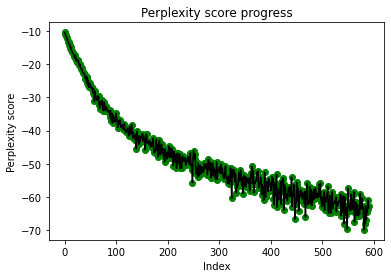

In [17]:
plt.title('Perplexity score progress')
plt.xlabel('Index')
plt.ylabel('Perplexity score')
plt.plot(indixes, perplexity_score, 'go', perplexity_score, 'k')
plt.show()

### Plot coherence score progress along incremental learning iterations  

Higher the coherence score represents a more human interpretable model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


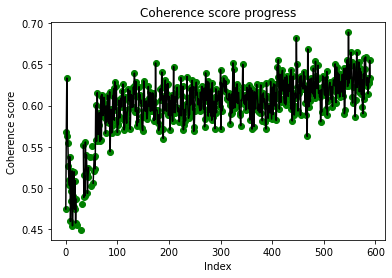

In [18]:
plt.title('Coherence score progress')
plt.xlabel('Index')
plt.ylabel('Coherence score')
plt.plot(indixes, coherence_score, 'go', coherence_score, 'k') 
plt.show()

### Visualize the topics-keywords

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.422026  0.180361       1        1  30.615545
8      0.122764 -0.387054       2        1  14.714680
2     -0.081586  0.124773       3        1   8.625012
4     -0.058878 -0.070605       4        1   8.354260
9      0.013862 -0.095440       5        1   8.257783
5     -0.060990  0.112942       6        1   7.886167
6     -0.060438 -0.004255       7        1   5.972413
3     -0.084541  0.017268       8        1   5.710001
7     -0.096265  0.049954       9        1   5.408938
1     -0.115954  0.072057      10        1   4.455200, topic_info=             Term       Freq      Total Category  logprob  loglift
25        fashion  81.000000  81.000000  Default  30.0000  30.0000
0          beauty  44.000000  44.000000  Default  29.0000  29.0000
330          food  30.000000  30.000000  Default  28.0000  28.0000
34          style  62.000000  62.000000  Default  27.0000  27.0000
42        blogger  34.000000  34.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
11035     colitis   2.034654   2.036211  Topic10  -4.5169   3.1103
23020        rash   2.034654   2.036211  Topic10  -4.5169   3.1103
359          band   3.049907   3.053828  Topic10  -4.1121   3.1098
5657      chronic   2.034654   2.036211  Topic10  -4.5169   3.1103
1819   restaurant   2.035943   2.038609  Topic10  -4.5162   3.1098

[355 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2971      5  1.015577      adult
531       3  1.020875  adventure
1876      7  1.001006      alert
704       5  1.016371      amaze
1588      9  0.994399    angeles
...     ...       ...        ...
842       5  1.016499       word
391       3  1.020991     writer
223       1  1.003055       year
922       3  1.021187       york
1244      4  1.009945      yummy

[330 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 3, 5, 10, 6, 7, 4, 8, 2])

### Save document-topic matrix (most significant topic per document)  
 https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
 https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [20]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

doc_num, topic_num, prob = [], [], []

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
    
data = {'Document': doc_num
        ,'Topic': topic_num
        ,'Probability': prob}
df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Document  Topic  Probability
0         541250      8     0.371284
1        1291946      8     0.300004
2         786049      3     0.723417
3         167502      0     0.633412
4        1319982      8     0.440497
...          ...    ...          ...
148086    405564      4     0.607668
148087     15142      7     0.275037
148088   1060159      0     0.310713
148089     81495      9     0.420030
148090    878524      8     0.700107

[148091 rows x 3 columns]


### Save document-topic matrix (all topic's probability per document)  
https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [21]:
doc_num = []
prob0, prob1, prob2, prob3, prob4, prob5, prob6, prob7, prob8, prob9 = ([] for i in range(num_topics))

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    prob0.append(get_document_topics[0][1])
    prob1.append(get_document_topics[1][1])
    prob2.append(get_document_topics[2][1])
    prob3.append(get_document_topics[3][1])
    prob4.append(get_document_topics[4][1])
    prob5.append(get_document_topics[5][1])
    prob6.append(get_document_topics[6][1])
    prob7.append(get_document_topics[7][1])
    prob8.append(get_document_topics[8][1])
    prob9.append(get_document_topics[9][1])
    
data = {'Document': doc_num
        ,'Topic0': prob0
        ,'Topic1': prob1
        ,'Topic2': prob2
        ,'Topic3': prob3
        ,'Topic4': prob4
        ,'Topic5': prob5
        ,'Topic6': prob6
        ,'Topic7': prob7
        ,'Topic8': prob8
        ,'Topic9': prob9}

df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix_full.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Document    Topic0    Topic1    Topic2    Topic3    Topic4    Topic5  \
0         541250  0.227978  0.010533  0.115939  0.221602  0.010533  0.010533   
1        1291946  0.241135  0.005881  0.064703  0.005881  0.182377  0.182371   
2         786049  0.160116  0.014558  0.014558  0.723417  0.014558  0.014558   
3         167502  0.633412  0.003704  0.114817  0.003704  0.003704  0.040689   
4        1319982  0.261777  0.005133  0.005133  0.005134  0.056469  0.107800   
...          ...       ...       ...       ...       ...       ...       ...   
148086    405564  0.010057  0.010057  0.010057  0.010060  0.607668  0.010057   
148087     15142  0.274961  0.024997  0.024997  0.024997  0.024997  0.024997   
148088   1060159  0.310717  0.162877  0.014795  0.014795  0.014795  0.014795   
148089     81495  0.019994  0.019994  0.019994  0.220020  0.019994  0.219994   
148090    878524  0.033321  0.033321  0.033321  0.033321  0.033321  0.033321   

          Topic6    Topic7    Topic8   

### Save topic-term matrix

In [22]:
# get topic-term-matrix
topic_term_matrix = lda_model.get_topics()
# save topic-term matrix
savetxt(file_model + '_topic_term_matrix.csv', topic_term_matrix, delimiter=',')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
